# 03 - DP

In [33]:
import ast
from copy import deepcopy
from functools import reduce

import findspark
from common.const import DATASET, FILEPATH, STAGING_FILENAME
from common.dataframe_utils import array_to_string, string_columns_encoder
from common.utils import (
    change_case,
    describe_dataframe_details,
    detect_continuous_variables,
    plot_column_value_count,
    rename_columns,
)
from common.z_score import abs_z_score, z_score
from pyspark.sql import DataFrame, SparkSession, Window
from pyspark.sql.functions import (
    array_contains,
    col,
    explode,
    greatest,
    monotonically_increasing_id,
    ntile,
    size,
    udf,
    when,
)
from pyspark.sql.types import ArrayType, StringType

In [2]:
findspark.init("/home/ubuntu/spark-3.2.1-bin-hadoop2.7")
spark = SparkSession.builder.appName("basics").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/22 19:27:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

## 3.4 Data Integration

In [4]:
filepath_list = [
    FILEPATH.CARBON_EMISSION_AMOUNT,
    FILEPATH.CARBON_EMISSION_HEALTH,
    FILEPATH.CARBON_EMISSION_LIFESTYLE,
    FILEPATH.CARBON_EMISSION_TRAVEL,
    FILEPATH.CARBON_EMISSION_WASTE,
]
df_list = [
    spark.read.csv(filepath, header=True, inferSchema=True)
    for filepath in filepath_list
]
for df in df_list:
    print(
        f"Type: {type(df)} | Shape: ({df.count()}, {len(df.columns)}) | Columns: {df.columns}"
    )
df_id = reduce(lambda x, y: x.join(y, on="ID", how="outer"), df_list)
df_id.show()

Type: <class 'pyspark.sql.dataframe.DataFrame'> | Shape: (10200, 2) | Columns: ['ID', 'CarbonEmission']
Type: <class 'pyspark.sql.dataframe.DataFrame'> | Shape: (10200, 3) | Columns: ['ID', 'Body Type', 'Sex']
Type: <class 'pyspark.sql.dataframe.DataFrame'> | Shape: (10200, 12) | Columns: ['ID', 'Diet', 'How Often Shower', 'Heating Energy Source', 'Social Activity', 'Monthly Grocery Bill', 'How Long TV PC Daily Hour', 'How Many New Clothes Monthly', 'How Long Internet Daily Hour', 'Energy efficiency', 'Recycling', 'Cooking_With']
Type: <class 'pyspark.sql.dataframe.DataFrame'> | Shape: (10200, 5) | Columns: ['ID', 'Transport', 'Vehicle Type', 'Frequency of Traveling by Air', 'Vehicle Monthly Distance Km']
Type: <class 'pyspark.sql.dataframe.DataFrame'> | Shape: (10200, 3) | Columns: ['ID', 'Waste Bag Size', 'Waste Bag Weekly Count']


+---+--------------+-----------+------+-----------+----------------+---------------------+---------------+--------------------+-------------------------+----------------------------+----------------------------+-----------------+--------------------+--------------------+------------+------------+-----------------------------+---------------------------+--------------+----------------------+
| ID|CarbonEmission|  Body Type|   Sex|       Diet|How Often Shower|Heating Energy Source|Social Activity|Monthly Grocery Bill|How Long TV PC Daily Hour|How Many New Clothes Monthly|How Long Internet Daily Hour|Energy efficiency|           Recycling|        Cooking_With|   Transport|Vehicle Type|Frequency of Traveling by Air|Vehicle Monthly Distance Km|Waste Bag Size|Waste Bag Weekly Count|
+---+--------------+-----------+------+-----------+----------------+---------------------+---------------+--------------------+-------------------------+----------------------------+----------------------------+-

In [5]:
df = df_id.drop("ID")
df.show()

+--------------+-----------+------+-----------+----------------+---------------------+---------------+--------------------+-------------------------+----------------------------+----------------------------+-----------------+--------------------+--------------------+------------+------------+-----------------------------+---------------------------+--------------+----------------------+
|CarbonEmission|  Body Type|   Sex|       Diet|How Often Shower|Heating Energy Source|Social Activity|Monthly Grocery Bill|How Long TV PC Daily Hour|How Many New Clothes Monthly|How Long Internet Daily Hour|Energy efficiency|           Recycling|        Cooking_With|   Transport|Vehicle Type|Frequency of Traveling by Air|Vehicle Monthly Distance Km|Waste Bag Size|Waste Bag Weekly Count|
+--------------+-----------+------+-----------+----------------+---------------------+---------------+--------------------+-------------------------+----------------------------+----------------------------+-------------

## 3.1 Data Selection

In [6]:
df = rename_columns(df=df)

In [7]:
df = df.drop(
    "energy_efficiency",
    "how_long_t_v_p_c_daily_hour",
    "how_often_shower",
)

In [8]:
df.show()

+---------------+-----------+------+-----------+---------------------+---------------+--------------------+----------------------------+----------------------------+--------------------+--------------------+------------+------------+-----------------------------+---------------------------+--------------+----------------------+
|carbon_emission|  body_type|   sex|       diet|heating_energy_source|social_activity|monthly_grocery_bill|how_many_new_clothes_monthly|how_long_internet_daily_hour|           recycling|        cooking_with|   transport|vehicle_type|frequency_of_traveling_by_air|vehicle_monthly_distance_km|waste_bag_size|waste_bag_weekly_count|
+---------------+-----------+------+-----------+---------------------+---------------+--------------------+----------------------------+----------------------------+--------------------+--------------------+------------+------------+-----------------------------+---------------------------+--------------+----------------------+
|         

## 3.2 Data Cleaning

In [9]:
df = df.na.fill(
    "not_applicable",
    subset=["vehicle_type"],
).na.drop()

In [10]:
describe_dataframe_details(df=df, spark=spark)

summary,count,mean,stddev,min,max,outlier_count,null_count
carbon_emission,10080,2268.6126984126986,1017.3791822295326,306,8377,128,0
body_type,10080,None,None,fat,very fat,None,0
sex,10080,None,None,f,male,None,0
diet,10080,None,None,omnivore,vegetarian,None,0
heating_energy_source,10080,None,None,coal,wood,None,0
social_activity,10080,None,None,never,sometimes,None,0
monthly_grocery_bill,10080,175.0986111111111,110.810280854913,1,8000,3,0
how_many_new_clothes_monthly,10080,25.08888888888889,14.709032126869957,0,50,0,0
how_long_internet_daily_hour,10080,11.924007936507936,7.397732093750228,0,95,5,0
recycling,10080,None,None,"['Glass', 'Metal']",[],None,0


In [11]:
def string_to_nested_list(s):
    return ast.literal_eval(s)


# Define the UDF
nested_list_udf = udf(string_to_nested_list, ArrayType((StringType())))
df = df.withColumn("recycling", nested_list_udf(df.recycling))
df = df.withColumn("cooking_with", nested_list_udf(df.cooking_with))
df.show()

+---------------+-----------+------+-----------+---------------------+---------------+--------------------+----------------------------+----------------------------+--------------------+--------------------+------------+--------------+-----------------------------+---------------------------+--------------+----------------------+
|carbon_emission|  body_type|   sex|       diet|heating_energy_source|social_activity|monthly_grocery_bill|how_many_new_clothes_monthly|how_long_internet_daily_hour|           recycling|        cooking_with|   transport|  vehicle_type|frequency_of_traveling_by_air|vehicle_monthly_distance_km|waste_bag_size|waste_bag_weekly_count|
+---------------+-----------+------+-----------+---------------------+---------------+--------------------+----------------------------+----------------------------+--------------------+--------------------+------------+--------------+-----------------------------+---------------------------+--------------+----------------------+
|   

In [12]:
inconsistent_values_pair = []
for column_name in df.columns:
    if df.schema[column_name].dataType == StringType():
        distribution_df = df.groupBy(column_name).count()
        distribution_df = distribution_df.where(
            col("count") / df.count() < 0.005
        ).select(column_name)
        for row in distribution_df.toLocalIterator():
            inconsistent_values_pair.append(
                tuple([next(iter(row.asDict())), next(iter(row.asDict().values()))])
            )
expr = " and ".join(
    f'({value_pair[0]} != "{value_pair[1]}")' for value_pair in inconsistent_values_pair
)
df = df.filter(expr)

In [13]:
describe_dataframe_details(df=df, spark=spark)

summary,count,mean,stddev,min,max,outlier_count,null_count
carbon_emission,10061,2268.631646953583,1017.2817747472733,306,8377,128,0
body_type,10061,None,None,normal,underweight,None,0
sex,10061,None,None,female,male,None,0
diet,10061,None,None,omnivore,vegetarian,None,0
heating_energy_source,10061,None,None,coal,wood,None,0
social_activity,10061,None,None,never,sometimes,None,0
monthly_grocery_bill,10061,175.09591491899414,110.86654006495617,1,8000,3,0
how_many_new_clothes_monthly,10061,25.09094523407216,14.706140050332792,0,50,0,0
how_long_internet_daily_hour,10061,11.921280190835901,7.395794664456366,0,95,5,0
transport,10061,None,None,private,walk/bicycle,None,0


In [14]:
continuous_columns = detect_continuous_variables(df)
continuous_columns.remove(change_case(DATASET.TARGET))
abs_z_df = abs_z_score(df=df, columns=continuous_columns)
for column_name in abs_z_df.columns:
    abs_z_df = abs_z_df.withColumnRenamed(column_name, column_name + "_abs_z")
abs_z_df = (
    abs_z_df.withColumn(
        "max", greatest(*[abs_z_df[column_name] for column_name in abs_z_df.columns])
    )
    .select("max")
    .withColumn("ID", monotonically_increasing_id())
)
df = (
    df.withColumn("ID", monotonically_increasing_id())
    .join(abs_z_df, on="ID", how="inner")
    .drop("ID")
    .filter(col("max") <= 3)
    .drop("max")
)

In [15]:
describe_dataframe_details(df=df, spark=spark)

summary,count,mean,stddev,min,max,outlier_count,null_count
carbon_emission,10048,2268.528861464968,1017.426270717533,306,8377,128,0
body_type,10048,None,None,normal,underweight,None,0
sex,10048,None,None,female,male,None,0
diet,10048,None,None,omnivore,vegetarian,None,0
heating_energy_source,10048,None,None,coal,wood,None,0
social_activity,10048,None,None,never,sometimes,None,0
monthly_grocery_bill,10048,173.86664012738854,72.24335229354469,1,299,0,0
how_many_new_clothes_monthly,10048,25.08857484076433,14.705493348624131,0,50,0,0
how_long_internet_daily_hour,10048,11.892416401273886,7.277222530916896,0,24,0,0
transport,10048,None,None,private,walk/bicycle,None,0


In [16]:
df.show(truncate=False)

+---------------+-----------+------+-----------+---------------------+---------------+--------------------+----------------------------+----------------------------+------------------------------+-----------------------------------+------------+--------------+-----------------------------+---------------------------+--------------+----------------------+
|carbon_emission|body_type  |sex   |diet       |heating_energy_source|social_activity|monthly_grocery_bill|how_many_new_clothes_monthly|how_long_internet_daily_hour|recycling                     |cooking_with                       |transport   |vehicle_type  |frequency_of_traveling_by_air|vehicle_monthly_distance_km|waste_bag_size|waste_bag_weekly_count|
+---------------+-----------+------+-----------+---------------------+---------------+--------------------+----------------------------+----------------------------+------------------------------+-----------------------------------+------------+--------------+--------------------------

## 3.3 Data Construction

In [19]:
def explode_list_column(df: DataFrame, column_to_explodes: list[str]) -> DataFrame:
    for column_to_explode in column_to_explodes:
        df_unique_values = (
            df.withColumn("flattened", explode(column_to_explode))
            .select("flattened")
            .distinct()
        )
        value = [row.flattened for row in df_unique_values.collect()]
        for column_name in value:
            df = df.withColumn(
                f"{column_to_explode}_{column_name.lower()}",
                array_contains(df[column_to_explode], column_name),
            )
            df = df.withColumn(
                f"{column_to_explode}_{column_name.lower()}",
                when(
                    df[f"{column_to_explode}_{column_name.lower()}"] == True, 1
                ).otherwise(0),
            )
        df = df.withColumn(f"{column_to_explode}_count", size(df[column_to_explode]))
    return df

In [20]:
df = explode_list_column(df=df, column_to_explodes=["recycling", "cooking_with"])

In [32]:
df.show()

24/05/22 19:39:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 19:39:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 19:39:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 19:39:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 19:39:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 19:39:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 1

+---------------+-----------+------+-----------+---------------------+---------------+--------------------+----------------------------+----------------------------+--------------------+--------------------+------------+--------------+-----------------------------+---------------------------+--------------+----------------------+---------------+---------------+-----------------+---------------+---------------+-----------------+----------------------+---------------------+------------------+------------------+------------------+-----------------------------+
|carbon_emission|  body_type|   sex|       diet|heating_energy_source|social_activity|monthly_grocery_bill|how_many_new_clothes_monthly|how_long_internet_daily_hour|           recycling|        cooking_with|   transport|  vehicle_type|frequency_of_traveling_by_air|vehicle_monthly_distance_km|waste_bag_size|waste_bag_weekly_count|recycling_metal|recycling_glass|recycling_plastic|recycling_paper|recycling_count|cooking_with_oven|cooki

In [22]:
windowSpec = Window.orderBy("monthly_grocery_bill")
df = df.withColumn("monthly_grocery_bill_quantile", ntile(3).over(windowSpec))

In [23]:
df.show()

24/05/22 19:29:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 19:29:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 19:29:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 19:29:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 19:29:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 19:29:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 1

+---------------+-----------+------+-----------+---------------------+---------------+--------------------+----------------------------+----------------------------+--------------------+--------------------+------------+--------------+-----------------------------+---------------------------+--------------+----------------------+---------------+---------------+-----------------+---------------+---------------+-----------------+----------------------+---------------------+------------------+------------------+------------------+-----------------------------+
|carbon_emission|  body_type|   sex|       diet|heating_energy_source|social_activity|monthly_grocery_bill|how_many_new_clothes_monthly|how_long_internet_daily_hour|           recycling|        cooking_with|   transport|  vehicle_type|frequency_of_traveling_by_air|vehicle_monthly_distance_km|waste_bag_size|waste_bag_weekly_count|recycling_metal|recycling_glass|recycling_plastic|recycling_paper|recycling_count|cooking_with_oven|cooki

24/05/22 19:29:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 19:29:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 19:29:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 19:29:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 19:29:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 19:29:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 1

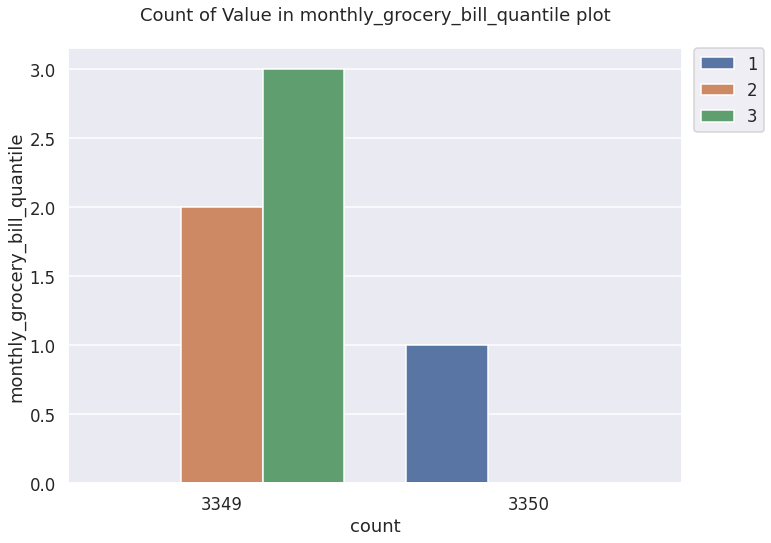

In [24]:
plot_column_value_count(df=df, column_name="monthly_grocery_bill_quantile")

In [25]:
encoded_df = array_to_string(df=df)

In [26]:
encoded_df = string_columns_encoder(df=encoded_df)

In [27]:
encoded_df.show()

24/05/22 19:29:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 19:29:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 19:30:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 19:30:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 19:30:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 19:30:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 1

+---------------+--------------------+----------------------------+----------------------------+---------------------------+----------------------+---------------+---------------+-----------------+---------------+---------------+-----------------+----------------------+---------------------+------------------+------------------+------------------+-----------------------------+---------+---+----+---------------------+---------------+---------+------------+---------+------------+-----------------------------+--------------+
|carbon_emission|monthly_grocery_bill|how_many_new_clothes_monthly|how_long_internet_daily_hour|vehicle_monthly_distance_km|waste_bag_weekly_count|recycling_metal|recycling_glass|recycling_plastic|recycling_paper|recycling_count|cooking_with_oven|cooking_with_microwave|cooking_with_airfryer|cooking_with_grill|cooking_with_stove|cooking_with_count|monthly_grocery_bill_quantile|body_type|sex|diet|heating_energy_source|social_activity|recycling|cooking_with|transport|veh

In [28]:
continuous_columns = [
    "monthly_grocery_bill",
    "vehicle_monthly_distance_km",
    "waste_bag_weekly_count",
    "how_many_new_clothes_monthly",
    "how_long_internet_daily_hour",
]
encoded_df_with_z = encoded_df.withColumn("id", monotonically_increasing_id())
z_score_df = z_score(df=encoded_df_with_z, columns=deepcopy(continuous_columns))
encoded_df_with_z = encoded_df_with_z.drop(*continuous_columns)
encoded_df_with_z = encoded_df_with_z.join(z_score_df, on="id", how="inner").drop("id")
encoded_df_with_z.show()

24/05/22 19:30:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 19:30:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 19:30:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 19:30:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 19:30:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 19:30:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 1

+---------------+---------------+---------------+-----------------+---------------+---------------+-----------------+----------------------+---------------------+------------------+------------------+------------------+-----------------------------+---------+---+----+---------------------+---------------+---------+------------+---------+------------+-----------------------------+--------------+--------------------+---------------------------+----------------------+----------------------------+----------------------------+
|carbon_emission|recycling_metal|recycling_glass|recycling_plastic|recycling_paper|recycling_count|cooking_with_oven|cooking_with_microwave|cooking_with_airfryer|cooking_with_grill|cooking_with_stove|cooking_with_count|monthly_grocery_bill_quantile|body_type|sex|diet|heating_energy_source|social_activity|recycling|cooking_with|transport|vehicle_type|frequency_of_traveling_by_air|waste_bag_size|monthly_grocery_bill|vehicle_monthly_distance_km|waste_bag_weekly_count|how

In [29]:
info_table = describe_dataframe_details(spark=spark, df=encoded_df_with_z)
info_table

24/05/22 19:30:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 19:30:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 19:30:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 19:30:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 19:30:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 19:30:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 1

summary,count,mean,stddev,min,max,outlier_count,null_count
carbon_emission,10048,2268.528861464968,1017.4262707175363,306,8377,128,0
recycling_metal,10048,0.5047770700636943,0.5000020603756642,0,1,0,0
recycling_glass,10048,0.49781050955414013,0.5000200883005704,0,1,0,0
recycling_plastic,10048,0.49990047770700635,0.5000248725253512,0,1,0,0
recycling_paper,10048,0.49781050955414013,0.5000200883005695,0,1,0,0
recycling_count,10048,2.000298566878981,1.009411228685086,0,4,0,0
cooking_with_oven,10048,0.5048765923566879,0.5000010995284541,0,1,0,0
cooking_with_microwave,10048,0.5079617834394905,0.4999614852613986,0,1,0,0
cooking_with_airfryer,10048,0.49850716560509556,0.5000226537601303,0,1,0,0
cooking_with_grill,10048,0.49850716560509556,0.5000226537601303,0,1,0,0


## Write Data 

In [35]:
encoded_df_with_z.repartition(2).write.mode("overwrite").parquet(
    f"{FILEPATH.TEMP_STAGING_PATH}/{STAGING_FILENAME.DP}.parquet"
)

24/05/22 21:14:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 21:14:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 21:14:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 21:14:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 21:14:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 21:14:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/22 2